In [1]:
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import sklearn.metrics as metrics

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

DATA = Path('../data/')

In [121]:
def collapse_list_of_list(list_of_list): 
    return [elem for lst in list_of_list for elem in lst]

def train_valid_test_split(cases_deaths_features, min_deaths=10, num_days=10):
    log_min_deaths = np.log(min_deaths)
    
    # Keep only those counties which have experienced a certain number of minimum deaths
    countywise_log_max_deaths = cases_deaths_features.groupby('countyFIPS').agg({'log_deaths-0': max})['log_deaths-0']
    to_remove = list(countywise_log_max_deaths[countywise_log_max_deaths < log_min_deaths].index)
    cases_deaths_features = cases_deaths_features.loc[~cases_deaths_features.countyFIPS.isin(to_remove)]

    # Only move those counties to test set for which we can validate
    num_tspoints = cases_deaths_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]
    test_counties = num_tspoints[num_tspoints >= num_days].index.tolist()
    train_counties = num_tspoints[num_tspoints > num_days].index.tolist()

    # Sort
    cases_deaths_features.sort_values(['countyFIPS', 'days_since_first_death'], ascending=True, inplace=True)
    cases_deaths_features.reset_index(drop=True, inplace=True)

    # Get a list of indexes of the dataset corresponding to each county
    countywise_index = cases_deaths_features.reset_index().groupby('countyFIPS').agg({'index': list})['index']
    
    # Filtering steps
    # Find the number of time points for each county
    timepoints = countywise_index.map(len)

    # 1. Only keep those counties which correspond have at least num_days+1 time points.
    to_remove = timepoints[timepoints <= num_days+1]
    timepoints.drop(to_remove.index, inplace=True)

    # 2. Allocate county indices to train, validation and test set.
    train_counties = timepoints.index.tolist()
    valid_counties = timepoints[timepoints >= (2*num_days)+1].index.tolist()
    test_counties = timepoints.index.tolist()

    train_indices = collapse_list_of_list(countywise_index.map(lambda s: s[:-(2*num_days)]))
    valid_indices = collapse_list_of_list(countywise_index.loc[valid_counties].map(lambda s: s[-(2*num_days): -(num_days)]))
    test_indices = collapse_list_of_list(countywise_index.loc[test_counties].map(lambda s: s[-(num_days):]))

    # 3. Create datasets
    train = cases_deaths_features.iloc[train_indices]
    valid= cases_deaths_features.iloc[valid_indices]
    test = cases_deaths_features.iloc[test_indices]
    
    return train, valid, test


In [122]:
train

,countyFIPS,log_deaths-0,log_cases-0,log_neighbor_deaths-0,log_neighbor_cases-0,days_since_first_death,log_deaths-1,log_cases-1,log_neighbor_deaths-1,log_neighbor_cases-1,...,log_neighbor_deaths-3,log_neighbor_cases-3,log_deaths-4,log_cases-4,log_neighbor_deaths-4,log_neighbor_cases-4,log_deaths-5,log_cases-5,log_neighbor_deaths-5,log_neighbor_cases-5
0,01017,1.386294,4.406719,2.197225,5.509388,6,1.386294,4.219508,2.197225,5.337538,...,2.079442,4.997212,0.000000,3.610918,1.386294,4.962845,0.000000,3.332205,1.098612,4.682131
1,01017,1.609438,4.477337,2.397895,5.568345,7,1.386294,4.406719,2.197225,5.509388,...,2.197225,5.135798,1.098612,3.610918,2.079442,4.997212,0.000000,3.610918,1.386294,4.962845
2,01017,1.609438,4.510860,2.397895,5.645447,8,1.609438,4.477337,2.397895,5.568345,...,2.197225,5.337538,1.386294,3.828641,2.197225,5.135798,1.098612,3.610918,2.079442,4.997212
3,01017,1.609438,4.574711,2.484907,5.717028,9,1.609438,4.510860,2.397895,5.645447,...,2.197225,5.509388,1.386294,4.219508,2.197225,5.337538,1.386294,3.828641,2.197225,5.135798
4,01017,1.945910,4.634729,2.708050,5.831882,10,1.609438,4.574711,2.484907,5.717028,...,2.397895,5.568345,1.386294,4.406719,2.197225,5.509388,1.386294,4.219508,2.197225,5.337538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16785,55133,2.302585,5.476464,4.919981,7.821643,15,2.197225,5.416100,4.867534,7.778630,...,4.718499,7.722678,1.791759,5.308268,4.672829,7.686162,1.791759,5.267858,4.595120,7.640604
16786,55133,2.397895,5.505332,4.997212,7.865572,16,2.302585,5.476464,4.919981,7.821643,...,4.718499,7.742836,1.945910,5.347108,4.718499,7.722678,1.791759,5.308268,4.672829,7.686162
16787,55133,2.397895,5.545177,5.049856,7.903227,17,2.397895,5.505332,4.997212,7.865572,...,4.867534,7.778630,1.945910,5.389072,4.718499,7.742836,1.945910,5.347108,4.718499,7.722678
16788,55133,2.397895,5.560682,5.068904,7.930925,18,2.397895,5.545177,5.049856,7.903227,...,4.919981,7.821643,2.197225,5.416100,4.867534,7.778630,1.945910,5.389072,4.718499,7.742836


In [2]:
num_days = 10
min_deaths = 10
log_min_deaths = np.log(min_deaths)

# Read different feature files
stationary_features = pd.read_csv(DATA/'processed/abridged_stationary_features_median_imputed.tsv', 
                                  sep='\t', converters={'countyFIPS': str})

cases_deaths_features = pd.read_csv(DATA/'processed/abridged_time_varying_features.tsv',
                                    sep='\t', converters={'countyFIPS': str})

# Combine
# all_features = cases_deaths_features.merge(stationary_features, on='countyFIPS', how='left')

# Keep only those counties which have experienced a certain number of minimum deaths
countywise_log_max_deaths = cases_deaths_features.groupby('countyFIPS').agg({'log_deaths-0': max})['log_deaths-0']
to_remove = list(countywise_log_max_deaths[countywise_log_max_deaths < log_min_deaths].index)
print(f"{len(to_remove)} counties will be removed.")
cases_deaths_features = cases_deaths_features.loc[~cases_deaths_features.countyFIPS.isin(to_remove)]

# Only move those counties to test set for which we can validate
num_tspoints = cases_deaths_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]
test_counties = num_tspoints[num_tspoints >= num_days].index.tolist()
train_counties = num_tspoints[num_tspoints > num_days].index.tolist()

# Sort
cases_deaths_features.sort_values(['countyFIPS', 'days_since_first_death'], ascending=True, inplace=True)
cases_deaths_features.reset_index(drop=True, inplace=True)

# Get a list of indexes of the dataset corresponding to each county
countywise_index = cases_deaths_features.reset_index().groupby('countyFIPS').agg({'index': list})['index']

957 counties will be removed.


In [28]:
# Train models
# Find which columns we are predicting
target_columns = [col for col in train.columns if str(col).endswith('-0')]

# Initialize models
models = dict(zip(target_columns, [RandomForestRegressor(n_jobs=-1) for _ in range(len(target_columns))]))

# Train
for target, model in models.items():
    model.fit(train.drop(target_columns, axis=1), train[target])

In [118]:
def increment_colname(colname):
    lag = int(colname[-1])
    return colname[:-1] + str(lag + 1)

def evaluate(models, evaluation_ds):
    
    assert np.alltrue(evaluation_ds.sort_values(['countyFIPS', 'days_since_first_death']).index == evaluation_ds.index),\
        "Please pass dataset sorted in an ascending order for countyFIPS and days_since_first_death."
    
    # Find target columns
    target_columns = list(models.keys())
    
    # Dataset for the first iteration
    # Keep only the first time point
    eval_current_iter = evaluation_ds.drop_duplicates('countyFIPS', keep='first')
    # Remove target columns
    eval_current_iter = eval_current_iter.drop(target_columns, axis=1)

    # For storing predictions
    evaluation_ds_pred = evaluation_ds.loc[:, target_columns + ['countyFIPS']]
    evaluation_ds_pred[target_columns] = 0

    # Predict recursively
    for j in range(num_days):

        # Get predictions
        pred = pd.DataFrame({target: model.predict(eval_current_iter) for target, model in models.items()})

        # Set index to be the same as the ones getting predictions for
        pred.index = eval_current_iter.index

        # Store
        evaluation_ds_pred.loc[pred.index, pred.columns] = pred

        # Dataset for the next iteration
        # Increment index
        eval_current_iter.index = eval_current_iter.index+1
        # Increment column names
        eval_current_iter.drop([col[:-2]+'-5' for col in target_columns], inplace=True, axis=1)
        eval_current_iter.rename(
            {col: increment_colname(col) for col in eval_current_iter.columns if col.startswith('log_')},
            axis=1, inplace=True)
        # Get previous iteration predictions
        prev_pred = pred.copy(deep=True)
        prev_pred.index = prev_pred.index+1
        prev_pred.rename(
            {col: increment_colname(col) for col in prev_pred.columns if col.startswith('log_')},
            axis=1, inplace=True)
        eval_current_iter = pd.concat([eval_current_iter, prev_pred], axis=1)
        
    return evaluation_ds_pred

In [119]:
test_pred = evaluate(models, test)

metrics.mean_absolute_error(
    np.exp(test.drop_duplicates('countyFIPS', keep='last')['log_deaths-0']),
    np.exp(test_pred.drop_duplicates('countyFIPS', keep='last')['log_deaths-0'])
)

41.73634660704365

In [120]:
valid_pred = evaluate(models, valid)

metrics.mean_absolute_error(
    np.exp(valid.drop_duplicates('countyFIPS', keep='last')['log_deaths-0']),
    np.exp(valid_pred.drop_duplicates('countyFIPS', keep='last')['log_deaths-0'])
)

31.36438245295352

In [270]:
all_features.reset_index().reset_index().groupby('countyFIPS').agg({'index': list})['index']

countyFIPS
01017    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
01055    [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...
01073    [69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8...
01081    [99, 100, 101, 102, 103, 104, 105, 106, 107, 1...
01097    [134, 135, 136, 137, 138, 139, 140, 141, 142, ...
                               ...                        
55079    [16644, 16645, 16646, 16647, 16648, 16649, 166...
55101    [16690, 16691, 16692, 16693, 16694, 16695, 166...
55105    [16721, 16722, 16723, 16724, 16725, 16726, 167...
55127    [16755, 16756, 16757, 16758, 16759, 16760, 167...
55133    [16776, 16777, 16778, 16779, 16780, 16781, 167...
Name: index, Length: 465, dtype: object

In [300]:
def tscvsplit(indices):
    n = len(indices)
    train_indices = [indices[0:i] for i in range(1, n-num_days+1)]
    test_indices = [indices[i] for i in range(num_days, n)]
    
    assert len(train_indices) == len(test_indices), \
        "Lenght of train and test indices don't match"
    
    return train_indices, test_indices

In [299]:
tscvsplit(np.arange(12))

([array([0]), array([0, 1])], [10, 11])

In [293]:
X = np.arange(12)
num_days = 10

In [294]:
train_indices = [X[0:i] for i in range(1, X.shape[0]-num_days+1)]
test_indices = [X[i] for i in range(num_days, X.shape[0])]

In [296]:
train_indices

[array([0]), array([0, 1])]

In [297]:
test_indices

[10, 11]

In [295]:
len(test_indices)

2

In [291]:
train_indices[-1]

IndexError: list index out of range

In [292]:
test_indices[-1]

IndexError: list index out of range

In [285]:
assert len(train_indices) == len(test_indices)

n = len(train_indices)
for x, y
plot_x = train_indices
plot_y = 

[array([0]),
 array([0, 1]),
 array([0, 1, 2]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3, 4]),
 array([0, 1, 2, 3, 4, 5]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 1

In [ ]:
sns.heatmap()

In [284]:
sns.scatterplot(x=)

90

In [ ]:
targets = 
X.shape[0] - num_days

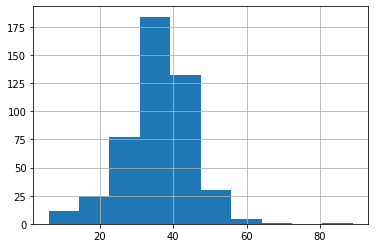

In [262]:
num_tspoints.hist()

In [194]:
num_days = 10
min_deaths = 10
log_min_deaths = np.log(min_deaths)

# Read different feature files
stationary_features = pd.read_csv(DATA/'processed/abridged_stationary_features_median_imputed.tsv', 
                                  sep='\t', converters={'countyFIPS': str})
cases_deaths_features = pd.read_csv(DATA/'processed/abridged_time_varying_features.tsv',
                                    sep='\t', converters={'countyFIPS': str})

# Combine
all_features = cases_deaths_features.merge(stationary_features, on='countyFIPS', how='left')

# Keep only those counties which have experienced a certain number of minimum deaths
countywise_log_max_deaths = all_features.groupby('countyFIPS').agg({'log_deaths-0': max})['log_deaths-0']
to_remove = list(countywise_log_max_deaths[countywise_log_max_deaths < log_min_deaths].index)
print(f"{len(to_remove)} counties will be removed.")
all_features = all_features.loc[~all_features.countyFIPS.isin(to_remove)]

# Only move those counties to test set for which we can validate
num_tspoints = all_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]
test_counties = num_tspoints[num_tspoints >= num_days].index.tolist()
train_counties = num_tspoints[num_tspoints > num_days].index.tolist()

# Sort
all_features.sort_values(['countyFIPS', 'days_since_first_death'], ascending=True, inplace=True)

# Encode categorical features
all_features['countyFIPS'] = all_features['countyFIPS'].astype('category')
all_features['StateName'] = all_features['StateName'].astype('category')
all_features['CensusRegionName'] = all_features['CensusRegionName'].astype('category')
all_features['CensusDivisionName'] = all_features['CensusDivisionName'].astype('category')
all_features.set_index('countyFIPS', inplace=True, drop=True)

# Construct train and test dataset
train = list()
test = list()

for county in train_counties:
    county_features = all_features.loc[county]
    train.append(county_features.iloc[:-num_days])
    
for county in test_counties:
    county_features = all_features.loc[county]
    test.append(county_features.iloc[-num_days:])

train = pd.concat(train)
test = pd.concat(test).reset_index()

# Just get rid of categorical features for now
x = train.dtypes == 'category'
todrop = x[x].index.tolist()
train.drop(todrop, inplace=True, axis=1)
test.drop(todrop, inplace=True, axis=1)

957 counties will be removed.


In [198]:
# Find which columns we are predicting
target_columns = [col for col in train.columns if str(col).endswith('-0')]

# Initialize models
models = dict(zip(target_columns, [RandomForestRegressor(n_jobs=-1) for _ in range(len(target_columns))]))

# Train
for target, model in models.items():
    model.fit(train.drop(target_columns, axis=1), train[target])

In [227]:
# Evaluation loop

#1. Find unique counties
counties = test.index.unique()

#2. Sort the data
test.sort_values(['countyFIPS', 'days_since_first_death'], inplace=True)

#3. Get index corresponding to each countyFIPS
countywise_index = test.reset_index().reset_index().groupby('countyFIPS').agg({'index': list})['index']
countywise_index = countywise_index[countywise_index.apply(len) == num_days]

In [252]:
predictions = list()
for i in range(num_days):
    
    # Get test subset for ith day
    test_subset = test.iloc[countywise_index.map(lambda s: s[i]).values]
    test_subset_X = test_subset.drop(target_columns, axis=1)
    test_subset_y_pred = dict()
    
    for target, model in models.items():
        test_subset_y_pred[target] = model.predict(test_subset_X)
    
    test_subset_y_pred = pd.DataFrame(test_subset_y_pred)
    test_subset_y_pred.index= test_subset_X.index
    
    # Calculate any error metrics
    
    # Overwrite observed i+1 with predicted
    if i+1 < num_days:
        for target in models.keys():
            test.iloc[countywise_index.map(lambda s: s[i+1]).values].\
                loc[:, [target[:-2] + '-1' for target in test_subset_y_pred.columns]] = test_subset_y_pred.values

    test_subset_y_pred['days_since_first_death'] = test_subset_X['days_since_first_death']
    predictions.append(test_subset_y_pred)

/anaconda/envs/py38_covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/anaconda/envs/py38_covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/anaconda/envs/py38_covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [253]:
y_pred = test_subset_y_pred
y_true = test_subset.loc[:,test_subset_y_pred.columns]

In [254]:
import sklearn.metrics as metrics

In [255]:
metrics.mean_absolute_error(np.exp(y_true['log_deaths-0']), np.exp(y_pred['log_deaths-0']))

13.420471328212637

In [240]:
x=test_subset_y_pred.columns[0]

In [241]:
x[:-2]

'log_deaths'

In [233]:
test_subset_y_pred

,log_deaths-0,log_cases-0,log_neighbor_deaths-0,log_neighbor_cases-0
0,3.081703,5.678664,4.421916,7.144371
1,2.087562,4.970941,3.033733,6.657853
2,3.843962,6.838158,4.104124,7.446498
3,3.359134,5.993951,4.416925,7.286698
4,4.041151,6.984382,4.221951,7.365293
...,...,...,...,...
459,5.215804,7.979392,5.561108,8.366245
460,2.500567,5.806033,5.492279,8.398310
461,1.847033,5.263127,4.063366,7.212011
462,2.163275,5.103168,4.617805,7.680929


In [ ]:
for target, model in models.items():

In [228]:
test_subset_X

,days_since_first_death,log_deaths-1,log_cases-1,log_neighbor_deaths-1,log_neighbor_cases-1,log_deaths-2,log_cases-2,log_neighbor_deaths-2,log_neighbor_cases-2,log_deaths-3,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
countyFIPS,,,,,,,,,,,,,,,,,,,,,
01017,33,3.044522,5.673323,4.356709,7.109062,2.944439,5.673323,4.276666,7.095893,2.890372,...,False,False,False,False,False,False,False,True,True,True
01055,28,2.079442,4.941642,2.995732,6.614726,2.079442,4.875197,2.995732,6.594413,2.079442,...,False,False,False,False,False,False,False,False,False,False
01073,26,3.784190,6.782192,4.043051,7.406103,3.713572,6.759255,3.951244,7.389564,3.583519,...,False,False,False,False,False,False,False,True,True,True
01081,31,3.332205,5.958425,4.369448,7.244228,3.218876,5.934894,4.276666,7.232733,3.178054,...,False,False,False,False,False,False,False,False,False,False
01097,32,3.970292,6.948897,4.174387,7.327781,3.828641,6.902743,4.060443,7.291656,3.761200,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55079,42,5.176150,7.943073,5.497168,8.326275,5.159055,7.909489,5.480639,8.290544,5.117994,...,False,False,False,False,False,False,False,True,True,True
55101,27,2.484907,5.762051,5.463832,8.366138,2.484907,5.733341,5.438079,8.326759,2.302585,...,False,False,False,False,False,False,False,True,True,True
55105,30,1.791759,5.214936,4.025352,7.170888,1.791759,5.187386,4.025352,7.118016,1.609438,...,False,False,False,False,False,False,False,False,False,False


In [224]:
test_subset = test.iloc[countywise_index.map(lambda s: s[i+1]).values]

In [226]:
test_subset_y_pred

,log_deaths-0,log_cases-0,log_neighbor_deaths-0,log_neighbor_cases-0
0,3.081703,5.678664,4.421916,7.144371
1,2.087562,4.970941,3.033733,6.657853
2,3.843962,6.838158,4.104124,7.446498
3,3.359134,5.993951,4.416925,7.286698
4,4.041151,6.984382,4.221951,7.365293
...,...,...,...,...
459,5.215804,7.979392,5.561108,8.366245
460,2.500567,5.806033,5.492279,8.398310
461,1.847033,5.263127,4.063366,7.212011
462,2.163275,5.103168,4.617805,7.680929


In [225]:
for col in test_subset_y_pred:
    test_subset

,log_deaths-0,log_cases-0,log_neighbor_deaths-0,log_neighbor_cases-0,days_since_first_death,log_deaths-1,log_cases-1,log_neighbor_deaths-1,log_neighbor_cases-1,log_deaths-2,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
countyFIPS,,,,,,,,,,,,,,,,,,,,,
01017,3.044522,5.673323,4.356709,7.122060,34,3.044522,5.673323,4.356709,7.119636,3.044522,...,False,False,False,False,False,False,False,True,True,True
01055,2.302585,4.941642,3.135494,6.638568,29,2.197225,4.941642,3.044522,6.620073,2.079442,...,False,False,False,False,False,False,False,False,False,False
01073,3.871201,6.835185,4.158883,7.444833,27,3.828641,6.787845,4.094345,7.415175,3.784190,...,False,False,False,False,False,False,False,True,True,True
01081,3.332205,5.971262,4.369448,7.271009,32,3.332205,5.971262,4.369448,7.259820,3.332205,...,False,False,False,False,False,False,False,False,False,False
01097,4.110874,7.003065,4.330733,7.375256,33,4.007333,6.964136,4.219508,7.341484,3.970292,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55079,5.225747,8.021256,5.564520,8.415603,43,5.198497,7.986505,5.529429,8.373323,5.176150,...,False,False,False,False,False,False,False,True,True,True
55101,2.564949,5.976351,5.537334,8.475120,28,2.484907,5.874931,5.497168,8.415825,2.484907,...,False,False,False,False,False,False,False,True,True,True
55105,1.791759,5.407172,4.043051,7.300473,31,1.791759,5.293305,4.043051,7.233455,1.791759,...,False,False,False,False,False,False,False,False,False,False


In [223]:
test_subset

,log_deaths-0,log_cases-0,log_neighbor_deaths-0,log_neighbor_cases-0,days_since_first_death,log_deaths-1,log_cases-1,log_neighbor_deaths-1,log_neighbor_cases-1,log_deaths-2,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
countyFIPS,,,,,,,,,,,,,,,,,,,,,
01017,3.044522,5.673323,4.356709,7.119636,33,3.044522,5.673323,4.356709,7.109062,2.944439,...,False,False,False,False,False,False,False,True,True,True
01055,2.197225,4.941642,3.044522,6.620073,28,2.079442,4.941642,2.995732,6.614726,2.079442,...,False,False,False,False,False,False,False,False,False,False
01073,3.828641,6.787845,4.094345,7.415175,26,3.784190,6.782192,4.043051,7.406103,3.713572,...,False,False,False,False,False,False,False,True,True,True
01081,3.332205,5.971262,4.369448,7.259820,31,3.332205,5.958425,4.369448,7.244228,3.218876,...,False,False,False,False,False,False,False,False,False,False
01097,4.007333,6.964136,4.219508,7.341484,32,3.970292,6.948897,4.174387,7.327781,3.828641,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55079,5.198497,7.986505,5.529429,8.373323,42,5.176150,7.943073,5.497168,8.326275,5.159055,...,False,False,False,False,False,False,False,True,True,True
55101,2.484907,5.874931,5.497168,8.415825,27,2.484907,5.762051,5.463832,8.366138,2.484907,...,False,False,False,False,False,False,False,True,True,True
55105,1.791759,5.293305,4.043051,7.233455,30,1.791759,5.214936,4.025352,7.170888,1.791759,...,False,False,False,False,False,False,False,False,False,False


In [222]:
test_subset_y_pred

,log_deaths-0,log_cases-0,log_neighbor_deaths-0,log_neighbor_cases-0
0,3.081703,5.678664,4.421916,7.144371
1,2.087562,4.970941,3.033733,6.657853
2,3.843962,6.838158,4.104124,7.446498
3,3.359134,5.993951,4.416925,7.286698
4,4.041151,6.984382,4.221951,7.365293
...,...,...,...,...
459,5.215804,7.979392,5.561108,8.366245
460,2.500567,5.806033,5.492279,8.398310
461,1.847033,5.263127,4.063366,7.212011
462,2.163275,5.103168,4.617805,7.680929


array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090,
       1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200,
       1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310,
       1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420,
       1430, 1440, 1450, 1460, 1470, 1480, 1490, 15

In [216]:
test

,log_deaths-0,log_cases-0,log_neighbor_deaths-0,log_neighbor_cases-0,days_since_first_death,log_deaths-1,log_cases-1,log_neighbor_deaths-1,log_neighbor_cases-1,log_deaths-2,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
countyFIPS,,,,,,,,,,,,,,,,,,,,,
01017,3.044522,5.673323,4.356709,7.119636,33,3.044522,5.673323,4.356709,7.109062,2.944439,...,False,False,False,False,False,False,False,True,True,True
01017,3.044522,5.673323,4.356709,7.122060,34,3.044522,5.673323,4.356709,7.119636,3.044522,...,False,False,False,False,False,False,False,True,True,True
01017,3.044522,5.686975,4.356709,7.145984,35,3.044522,5.673323,4.356709,7.122060,3.044522,...,False,False,False,False,False,False,False,True,True,True
01017,3.044522,5.707110,4.356709,7.159292,36,3.044522,5.686975,4.356709,7.145984,3.044522,...,False,False,False,False,False,False,False,True,True,True
01017,3.044522,5.713733,4.382027,7.170888,37,3.044522,5.707110,4.356709,7.159292,3.044522,...,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55133,2.995732,5.910797,5.556828,8.467162,35,2.995732,5.908083,5.529429,8.437067,2.995732,...,False,False,False,False,False,False,False,True,True,True
55133,3.091042,5.926926,5.579730,8.498826,36,2.995732,5.910797,5.556828,8.467162,2.995732,...,False,False,False,False,False,False,False,True,True,True
55133,3.091042,5.942799,5.613128,8.532673,37,3.091042,5.926926,5.579730,8.498826,2.995732,...,False,False,False,False,False,False,False,True,True,True
